In [69]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [3]:
def augment_images(folder_path):
  # flips image 3 times
  for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
      img_path = os.path.join(folder_path, filename)
      try:
        img = Image.open(img_path)

        # Horizontal flip
        h_flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        h_flipped_img.save(os.path.join(folder_path, f"hflip_{filename}"))

        # Vertical flip
        v_flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
        v_flipped_img.save(os.path.join(folder_path, f"vflip_{filename}"))

        hv_flipped_img = v_flipped_img
        hv_flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        hv_flipped_img.save(os.path.join(folder_path, f"hvflip_{filename}"))

      except IOError:
        print(f"Error opening or processing image: {filename}")

# Example usage (replace 'path/to/your/image/folder' with the actual path)
augment_images("dataset")


In [97]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [98]:
class AnimeDataset(Dataset):
    def __init__(self, image_paths, augment=False):
        self.image_paths = image_paths
        self.augment = augment

        # When augmentation is enabled, apply random horizontal flip,
        # random affine translation, random cropping (not fixed to the center),
        # brightness adjustment, and add a little Gaussian noise.
        if self.augment:
            self.aug_transform = transforms.Compose([
                transforms.RandomCrop((256, 256)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.ToTensor(),
            ])

        # For both training and non-training, use separate transforms to create low‑res and high‑res images.
        # These transforms are applied after augmentation (if any).
        self.low_res_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            AddGaussianNoise(mean=0.0, std=0.0005)
        ])
        self.high_res_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.augment:
            # Apply augmentation; note that the aug_transform returns a tensor.
            img_aug = self.aug_transform(img)
            # Convert back to a PIL image so that we can use the resize transforms.
            img_aug_pil = transforms.ToPILImage()(img_aug)
            low_res = self.low_res_transform(img_aug_pil)
            high_res = self.high_res_transform(img_aug_pil)
        else:
            low_res = self.low_res_transform(img)
            high_res = self.high_res_transform(img)
        return low_res, high_res

In [99]:
# Create list of image paths and split into train/validation/test sets.
image_dir = 'dataset'  # Update with your image folder
all_image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)
                   if img.endswith('.jpg') or img.endswith('.png')]
random.shuffle(all_image_paths)
total_size = len(all_image_paths)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size+val_size]
test_paths = all_image_paths[train_size+val_size:]

# Use augmentation only on training data.
train_dataset = AnimeDataset(train_paths, augment=True)
val_dataset = AnimeDataset(val_paths, augment=False)
test_dataset = AnimeDataset(test_paths, augment=False)

train_loader = DataLoader(train_dataset, batch_size=175, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=150, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=150, shuffle=False)

In [100]:
class VAE_UNet(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE_UNet, self).__init__()
        
        # Initial feature expansion: 64x64x3 -> 64x64x12
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Latent space components
        self.fc_mu = nn.Linear(12 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(12 * 64 * 64, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 12 * 64 * 64)
        
        # Decoder (Upsampling from 64x64x12 to 256x256x3)
        # Process the unfolded latent space back to image format
        self.process_latent = nn.Sequential(
            nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling: 64x64 -> 128x128
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling: 128x128 -> 256x256
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output normalized to [0,1]
        )

    def encode(self, x):
        # x: [B, 3, 64, 64]
        x = self.initial_conv(x)  # [B, 12, 64, 64]
        x_flat = x.view(x.size(0), -1)  # Flatten to [B, 12*64*64]
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        return mu, logvar, x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Project latent vector back to 64x64x12 space
        d = self.fc_decode(z)
        d = d.view(-1, 12, 64, 64)
        
        # Process through convolutional layers
        d = self.process_latent(d)  # [B, 32, 64, 64]
        
        # Upsampling
        d = self.dec1(d)  # [B, 16, 128, 128]
        d = self.dec2(d)  # [B, 3, 256, 256]
        
        return d

    def forward(self, x):
        mu, logvar, _ = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_UNet(latent_dim=128).to(device)
initial_lr = 2e-3
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Create a learning rate scheduler
lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100],  # Epochs at which to reduce learning rate
    gamma=0.5,             # Multiply learning rate by this factor (1/2)
    verbose=True           # Print message when LR changes
)

def edge_aware_loss(pred, target):
    # Sobel filters for edge detection
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).reshape(1, 1, 3, 3).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).reshape(1, 1, 3, 3).to(device)
    
    # Apply to each color channel
    pred_gray = 0.299 * pred[:, 0] + 0.587 * pred[:, 1] + 0.114 * pred[:, 2]
    target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
    
    pred_gray = pred_gray.unsqueeze(1)
    target_gray = target_gray.unsqueeze(1)
    
    # Get gradients
    pred_grad_x = F.conv2d(pred_gray, sobel_x, padding=1)
    pred_grad_y = F.conv2d(pred_gray, sobel_y, padding=1)
    target_grad_x = F.conv2d(target_gray, sobel_x, padding=1)
    target_grad_y = F.conv2d(target_gray, sobel_y, padding=1)
    
    # Compute edge loss
    edge_loss = F.l1_loss(pred_grad_x, target_grad_x) + F.l1_loss(pred_grad_y, target_grad_y)
    
    return edge_loss

# Update loss function
def loss_function(recon_x, x, mu, logvar, beta=10000.0, perceptual_weight=0.1, edge_weight=20000000):
    # Compute L1 loss over the reconstruction
    l1_loss = F.l1_loss(recon_x, x, reduction='sum')
    
    # Edge-preserving loss
    edge_loss = edge_aware_loss(recon_x, x)
    
    # Compute the KL divergence per image
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kld_loss = kld_loss / mu.size(1)  # Normalize by latent dimension
    
    # Combine losses with weights
    total_loss = l1_loss + edge_weight * edge_loss + beta * kld_loss
    
    return total_loss.mean(), l1_loss.mean(), kld_loss.mean(), edge_loss.mean()

In [113]:
num_epochs = 150
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_kld = 0.0
    total_images = 0
    total_l1 = 0
    total_edge = 0

    for low_res, high_res in train_loader:
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        optimizer.zero_grad()
        
        recon, mu, logvar = model(low_res)
        loss, l1, kld, edge = loss_function(recon, high_res, mu, logvar)
        loss.backward()
        optimizer.step()
        
        batch_size = low_res.size(0)
        total_images += batch_size
        total_loss += loss.item() * batch_size
        total_l1 += l1.item() * batch_size
        total_kld += kld.item() * batch_size
        total_edge += edge.item() * batch_size

    avg_loss = total_loss / total_images
    avg_l1 = total_l1 / total_images
    avg_kld = total_kld / total_images
    avg_edge = total_edge / total_images

    print(f"Epoch {epoch+1}: Average Loss per Image: {avg_loss:.4f}, L1: {avg_l1:.4f}, KLD: {avg_kld:.4f}, EDGE: {avg_edge:.4f}")



    val_total_loss = 0.0
    val_total_l1 = 0.0
    val_total_kld = 0.0
    val_total_images = 0
    total_edge = 0

    model.eval()
    with torch.no_grad():
        for low_res, high_res in val_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            recon, mu, logvar = model(low_res)
            loss, l1, kld, edge = loss_function(recon, high_res, mu, logvar)
            
            batch_size = low_res.size(0)
            val_total_loss += loss.item() * batch_size
            val_total_l1 += l1.item() * batch_size
            val_total_kld += kld.item() * batch_size
            val_total_images += batch_size
            total_edge += edge.item() * batch_size

    avg_val_loss = val_total_loss / val_total_images
    avg_val_l1 = val_total_l1 / val_total_images
    avg_val_kld = val_total_kld / val_total_images
    avg_edge = total_edge / total_images
    print(f"Epoch {epoch+1} | Validation Loss per Image: {avg_val_loss:.4f}, L1: {avg_val_l1:.4f}, KLD: {avg_val_kld:.4f}, EDGE: {avg_edge:.4f}")

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'VAE_best.pth')
        print("Saved new best model.")

    save_frequency = 5  # Save every 5 epochs
    if (epoch + 1) % save_frequency == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, f'VAE_epoch_{epoch+1}.pth')
        print(f"Saved checkpoint for epoch {epoch+1}")

    # At the end of each epoch
    lr_scheduler.step()

Epoch 1: Average Loss per Image: 11845424.5000, L1: 9429494.7500, KLD: 2.8235, EDGE: 0.1194
Epoch 1 | Validation Loss per Image: 13533749.0000, L1: 8209339.0000, KLD: 2.6581, EDGE: 0.0568
Saved new best model.
Epoch 2: Average Loss per Image: 12004004.7500, L1: 9583239.5000, KLD: 2.0987, EDGE: 0.1200
Epoch 2 | Validation Loss per Image: 13499351.0000, L1: 8203269.0000, KLD: 0.7327, EDGE: 0.0567
Saved new best model.
Epoch 3: Average Loss per Image: 11815915.2500, L1: 9453069.0000, KLD: 0.4607, EDGE: 0.1179
Epoch 3 | Validation Loss per Image: 13485781.0000, L1: 8196982.0000, KLD: 0.1196, EDGE: 0.0567
Saved new best model.
Epoch 4: Average Loss per Image: 11938792.7500, L1: 9601672.0000, KLD: 0.0837, EDGE: 0.1168
Epoch 4 | Validation Loss per Image: 13477629.0000, L1: 8190062.5000, KLD: 0.0241, EDGE: 0.0566
Saved new best model.
Epoch 5: Average Loss per Image: 12097602.7500, L1: 9708125.2500, KLD: 0.0231, EDGE: 0.1195
Epoch 5 | Validation Loss per Image: 13469796.0000, L1: 8182592.0000

KeyboardInterrupt: 

C:\Users\ruhalis\AppData\Local\Temp\ipykernel_2900\3891471887.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('VAE_best.pth'))


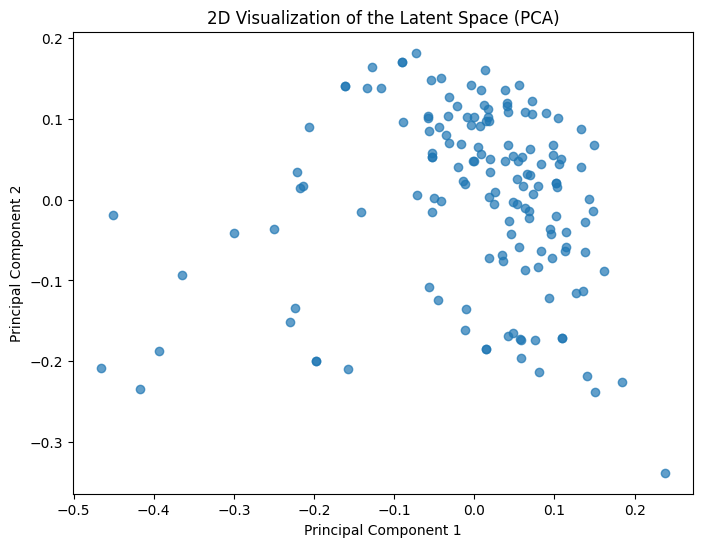

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0006840505..1.0014492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0005636239..1.0012875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0018711566..1.0013847].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0016842011..1.0011183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07004238..1.0015087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07539055..1.0011208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

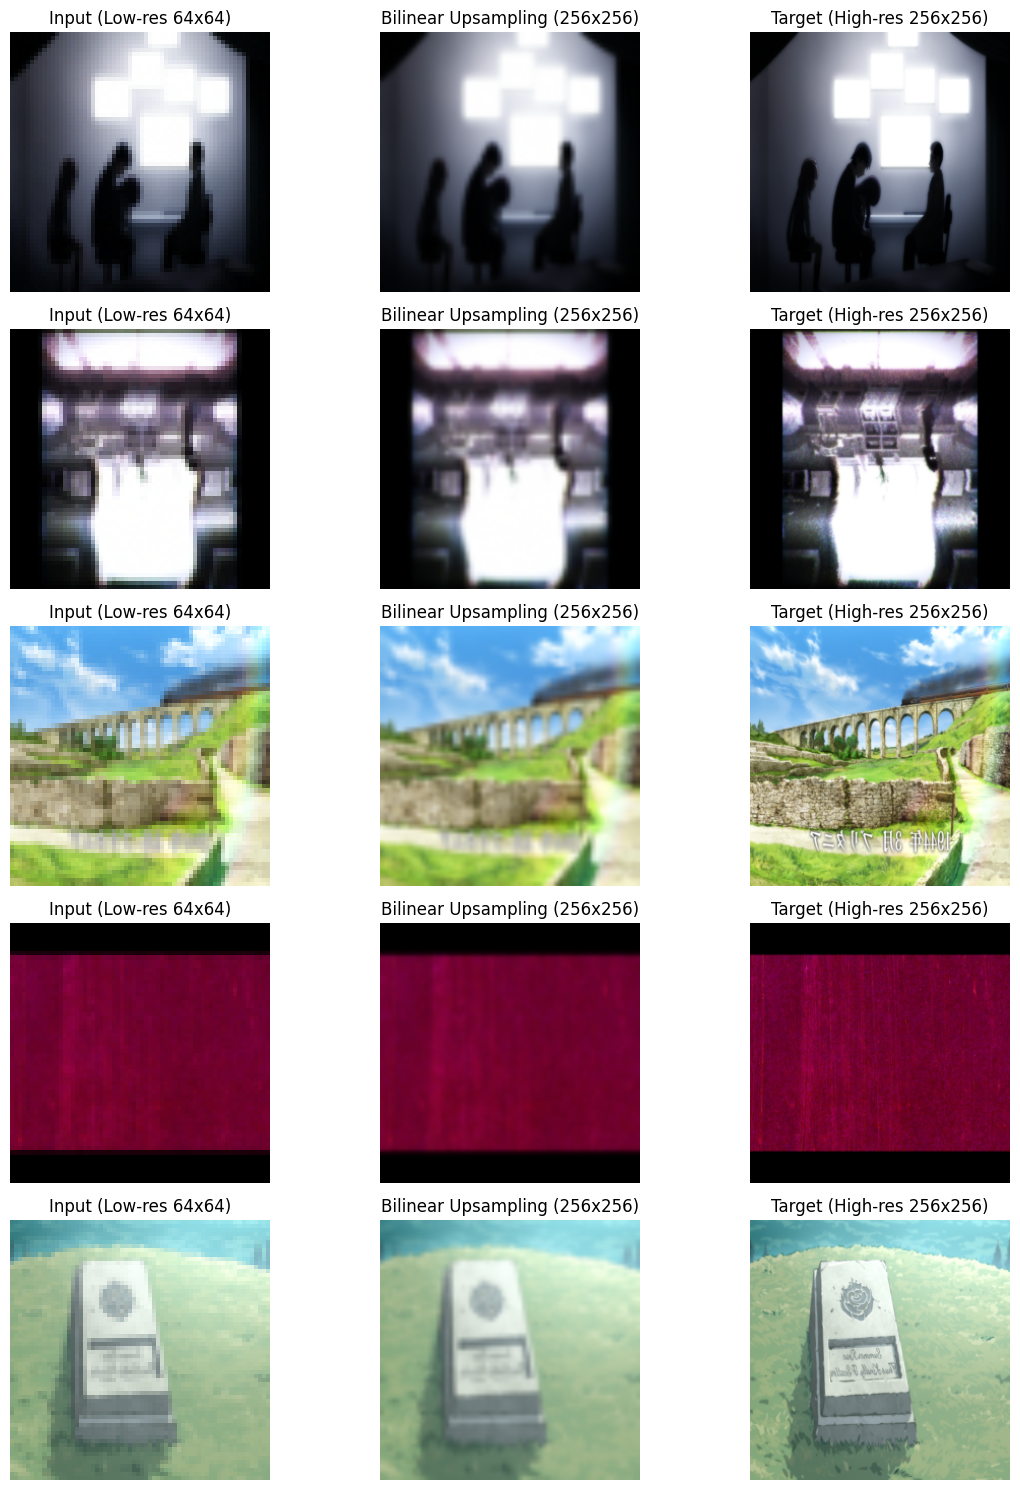

In [114]:
model.load_state_dict(torch.load('VAE_best.pth'))

# Visualize the latent space using PCA on test images
# Visualize the latent space using random inputs
model.eval()
latents = []
with torch.no_grad():
    for low_res, _ in test_loader:
        low_res = low_res.to(device)
        # Use only mu for visualization
        mu, _, _ = model.encode(low_res)
        latents.append(mu.cpu().numpy())

latents = np.concatenate(latents, axis=0)
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latents)

# Visualize the 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("2D Visualization of the Latent Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
with torch.no_grad():
    low_res_batch, high_res_batch = next(iter(test_loader))
    
    # Generate upsampled versions of low-res images using bilinear interpolation
    # This provides a simple baseline for comparison
    upsampled_batch = F.interpolate(low_res_batch, size=(256, 256), mode='bilinear', align_corners=False)
    
    # Convert tensors to numpy arrays for visualization
    low_res_np = low_res_batch.cpu().numpy()
    upsampled_np = upsampled_batch.cpu().numpy() 
    high_res_np = high_res_batch.cpu().numpy()

# Display the results
num_images = min(5, low_res_np.shape[0])
fig, axes = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))

for i in range(num_images):
    # Original low-res input (64x64)
    axes[i, 0].imshow(np.transpose(low_res_np[i], (1, 2, 0)))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Input (Low-res 64x64)")

    # Simple bilinear upsampling (256x256)
    axes[i, 1].imshow(np.transpose(upsampled_np[i], (1, 2, 0)))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Bilinear Upsampling (256x256)")

    # Target high-res image (256x256)
    axes[i, 2].imshow(np.transpose(high_res_np[i], (1, 2, 0)))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Target (High-res 256x256)")

plt.tight_layout()
plt.show()

C:\Users\ruhalis\AppData\Local\Temp\ipykernel_2900\1430949080.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('VAE_epoch_15.pth')


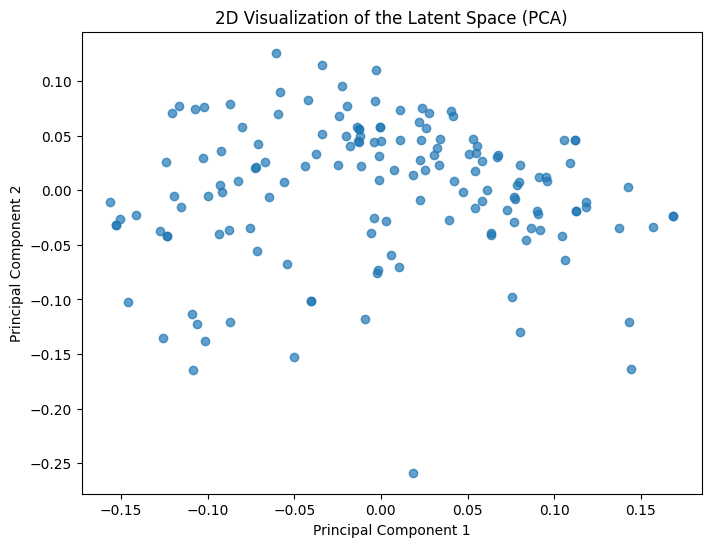

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00096568046..1.0015304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00093562744..1.0012755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0021589727..1.0016235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0016665448..1.0013595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0714188..1.0010357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.076397754..1.0009853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ra

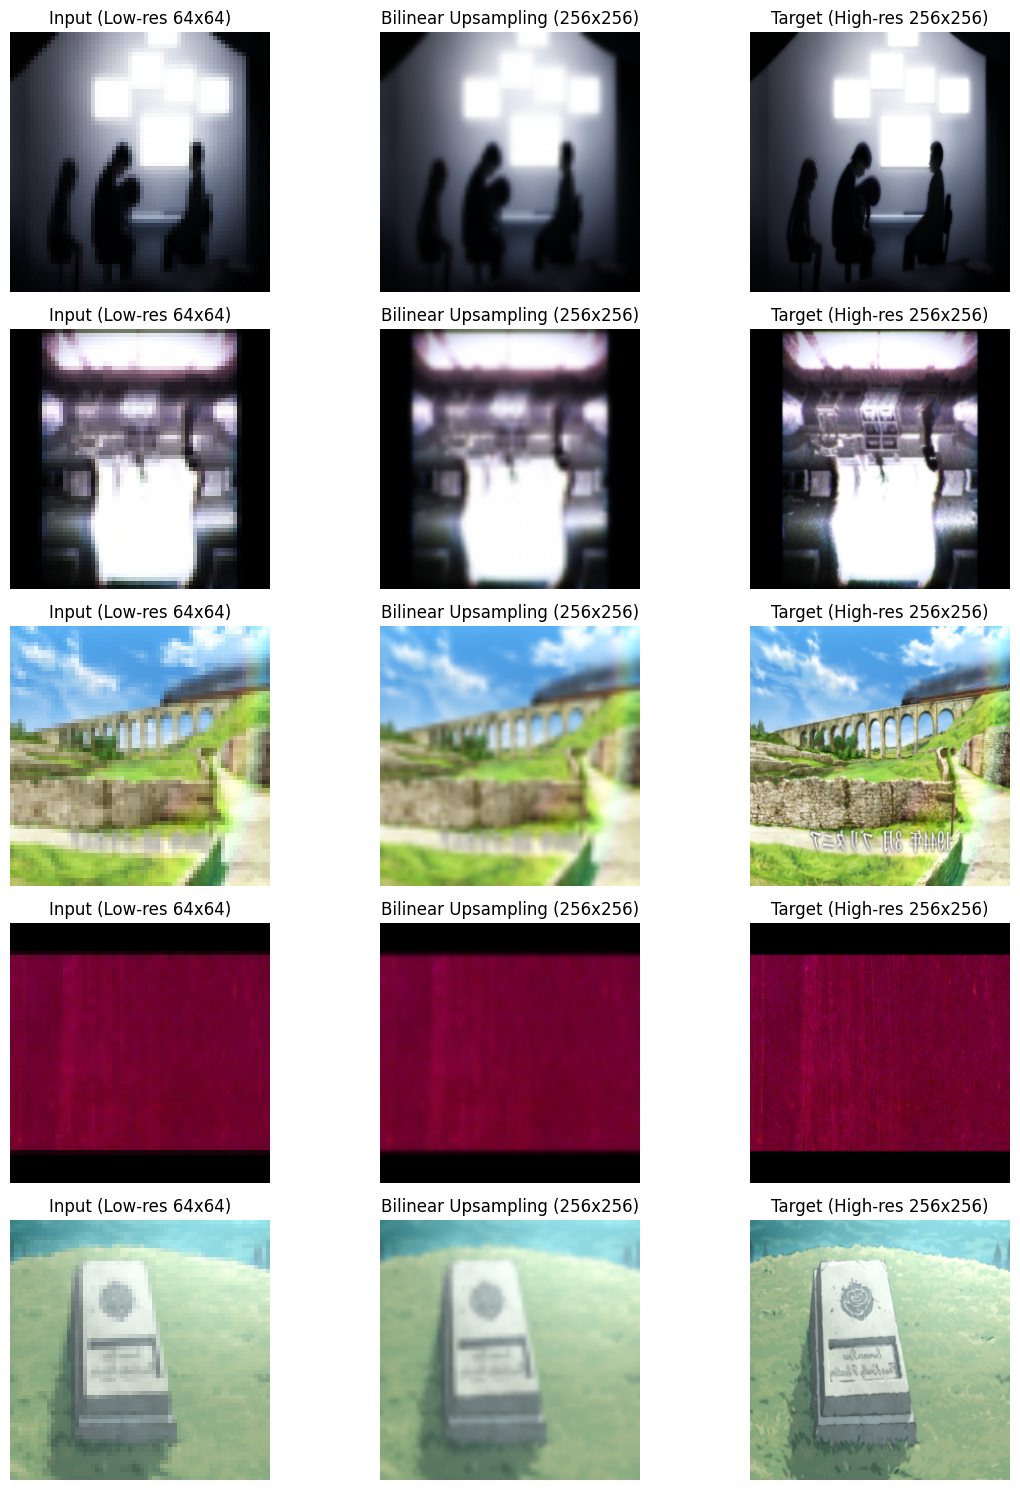

In [115]:
checkpoint = torch.load('VAE_epoch_15.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Visualize the latent space using PCA on test images
model.eval()
latents = []
with torch.no_grad():
    for low_res, _ in test_loader:
        low_res = low_res.to(device)
        # Use only mu for visualization
        mu, _, _ = model.encode(low_res)
        latents.append(mu.cpu().numpy())
latents = np.concatenate(latents, axis=0)
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latents)

# Visualize the 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("2D Visualization of the Latent Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
with torch.no_grad():
    low_res_batch, high_res_batch = next(iter(test_loader))
    
    # Generate upsampled versions of low-res images using bilinear interpolation
    # This provides a simple baseline for comparison
    upsampled_batch = F.interpolate(low_res_batch, size=(256, 256), mode='bilinear', align_corners=False)
    
    # Convert tensors to numpy arrays for visualization
    low_res_np = low_res_batch.cpu().numpy()
    upsampled_np = upsampled_batch.cpu().numpy() 
    high_res_np = high_res_batch.cpu().numpy()

# Display the results
num_images = min(5, low_res_np.shape[0])
fig, axes = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))

for i in range(num_images):
    # Original low-res input (64x64)
    axes[i, 0].imshow(np.transpose(low_res_np[i], (1, 2, 0)))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Input (Low-res 64x64)")

    # Simple bilinear upsampling (256x256)
    axes[i, 1].imshow(np.transpose(upsampled_np[i], (1, 2, 0)))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Bilinear Upsampling (256x256)")

    # Target high-res image (256x256)
    axes[i, 2].imshow(np.transpose(high_res_np[i], (1, 2, 0)))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Target (High-res 256x256)")

plt.tight_layout()
plt.show()